# Llava - Large Language and Vision Assistant (based on CLIP and LLama)

See: https://huggingface.co/docs/transformers/main/en/model_doc/llava <br>
Paper: https://arxiv.org/abs/2304.08485

In [1]:
import pandas as pd
df = pd.read_excel("../team5_project_data.xlsx", index_col=0)
# # [20, 21, 25, 40]
i = 40
image_url = df.iloc[i]["image_link"]
df.iloc[i-1:].head()

,image_link,temperature,description,logits,hallucinations,hedges,probe_1,label_1,pred_1,context_1,...,pred_2,context_2,probe_3,label_3,pred_3,context_3,probe_4,label_4,pred_4,context_4
39,https://cdn.pixabay.com/photo/2021/02/08/07/51...,0.8,The image features a group of people standing...,"[{' A': 0.007907885126769543, ' The': 0.819328...",The image features a group of people standing ...,The image features a group of people standing ...,The people likely to fishermen.,True,False,The image features a group of people standing ...,...,False,The image features a group of people standing ...,There are more than two boats.,True,True,The image features a group of people standing ...,The man that holding the fish move into the gr...,True,True,The image features a group of people standing ...
40,https://cdn.pixabay.com/photo/2020/04/21/06/41...,0.8,"The image features a white dog in the air, ap...","[{' A': 0.005038315895944834, ' The': 0.808513...","The image features a [white] dog in the air, a...","The image features a white dog in the air, app...",The dog in the air is completely white.,True,True,"The image features [a white dog in the air], a...",...,True,"The image features a white dog in the air, app...",One of the dog catch the frisbee with his hand.,False,False,"The image features [a white dog in the air, ap...",The white cat in the air.,False,True,"The image features [a white dog in the air], a..."
41,https://cdn.pixabay.com/photo/2013/02/21/19/10...,0.8,"In this heartwarming scene, a woman is holdin...","[{' A': 0.04947695508599281, ' The': 0.7046893...","In this heartwarming scene, a woman is holding...","In this heartwarming scene, a woman is holding...",The child holding his mother.,False,False,"In this heartwarming scene, [a woman is holdin...",...,False,"In this heartwarming scene, a woman is holding...",Only the woman wearing hat.,True,False,"In this heartwarming scene, a woman is holding...",Both the woman and the child looks happy.,True,True,"In this heartwarming scene, a woman is holding..."
42,https://cdn.pixabay.com/photo/2020/05/05/19/58...,0.8,"The image depicts a group of people, specific...","[{' A': 0.01196238026022911, ' The': 0.8386276...","The image depicts a group of people, specifica...","The image depicts a group of people, specifica...",There are five women.,False,True,"The image depicts a group of people, specifica...",...,False,"The image depicts a group of people, specifica...",The women looks angry.,False,True,"The image depicts a group of people, specifica...",The women do a messy and fun activity.,True,True,"The image depicts a group of people, specifica..."
43,https://cdn.pixabay.com/photo/2020/07/23/15/06...,0.8,The scene depicts a woman sitting down and us...,"[{' A': 0.08171854168176651, ' The': 0.6842209...",The scene depicts a woman sitting down and usi...,The scene depicts a woman sitting down and usi...,There are two person in the scene.,True,True,[The scene depicts a woman] sitting down and u...,...,True,[The scene depicts a woman sitting down and us...,The woman is holding the phone only with one h...,True,False,The scene depicts a woman sitting down and usi...,The woman is elegantly dressed.,False,True,The scene depicts a woman sitting down and usi...


In [2]:
from PIL import Image
import requests
import torch
from transformers import (BitsAndBytesConfig, AutoProcessor,
                          LlavaForConditionalGeneration, GenerationConfig)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def generate(image, prompt, processor, model, temperature=1.0):
    generation_config = GenerationConfig(max_new_tokens=200,
                                         do_sample=True,
                                         temperature=temperature,
                                         output_scores=True,
                                         return_dict_in_generate=True)
    device = model.device
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generate_outputs = model.generate(**inputs, generation_config=generation_config)
    # we extracted the *scores* of the model, which are after applying the temperature
    # and before the SoftMax. For converting them into logits,
    # we need to multiply them by the temperature.
    generate_outputs['scores'] = [x*temperature for x in generate_outputs['scores']]
    return generate_outputs


def extract_logits(processor, generate_outputs, min_prob=1e-3):
    scores_len = len(generate_outputs['scores'])
    generated_ids = generate_outputs['sequences'].tolist()[0][-scores_len:]
    generated_scores = []
    for i, token_id in enumerate(generated_ids):
        token = processor.tokenizer._convert_id_to_token(token_id).replace("▁", " ")
        logits = torch.softmax(generate_outputs['scores'][i], dim=-1)[0].tolist()
        logits = {t: round(p, 4) for t, p in enumerate(logits) if (p > min_prob or t == token_id)}
        logits = {processor.tokenizer._convert_id_to_token(t).replace("▁", " ").strip(): p for t, p in logits.items()}
        generated_scores.append((token, logits))
    generated_text = ''.join([x for x, _ in generated_scores])
    return generated_text, generated_scores

In [4]:
def generate_probe_pred(image, prompt, processor, model, temperature=1.0):
    generation_config = GenerationConfig(max_new_tokens=200,
                                         do_sample=True,
                                         temperature=temperature,
                                         output_scores=False,
                                         return_dict_in_generate=False)
    device = model.device
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generate_outputs = model.generate(**inputs, generation_config=generation_config)
    decoded_output = processor.tokenizer.decode(generate_outputs[0], skip_special_tokens=True).split("ASSISTANT:")[1]
    return decoded_output

In [5]:
model_name = 'llava-hf/llava-1.5-7b-hf'
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.bfloat16)

model = LlavaForConditionalGeneration.from_pretrained(model_name,
                                                      quantization_config=quantization_config)
processor = AutoProcessor.from_pretrained(model_name)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]
/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


USER: <image>
Please provide a thorough description of this image
ASSISTANT:


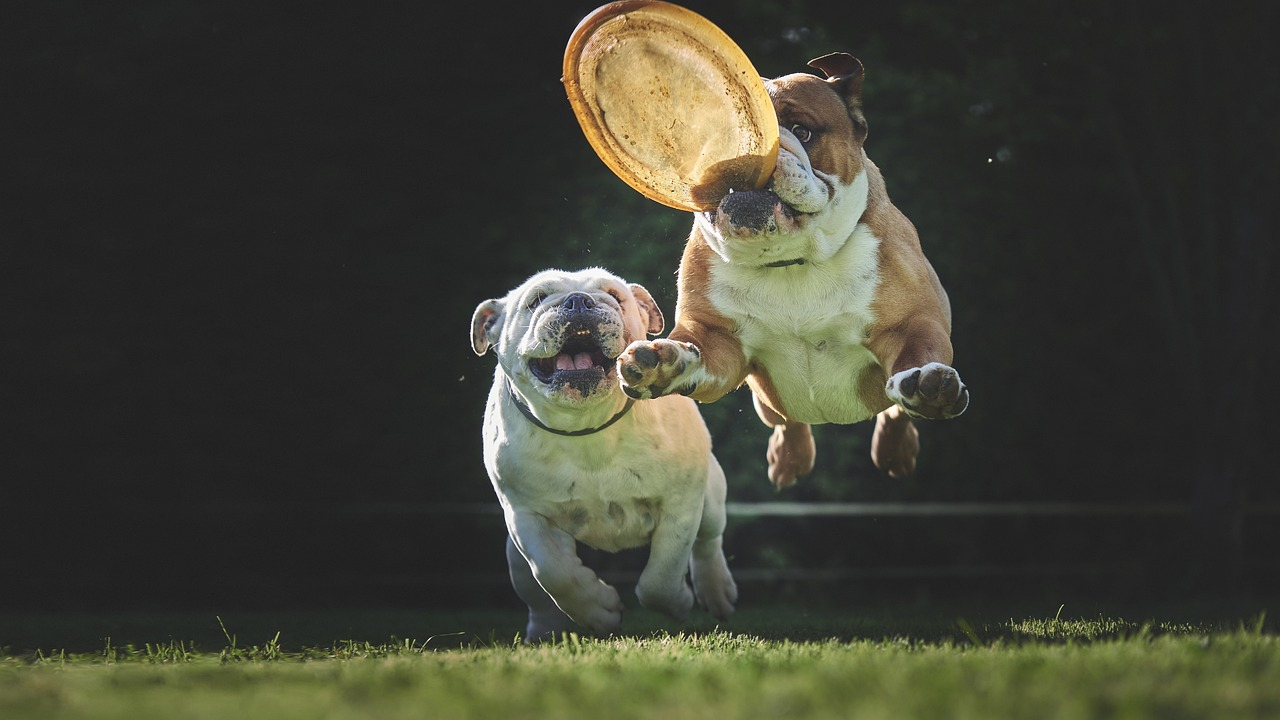

In [6]:
image = Image.open(requests.get(image_url, stream=True).raw)
instruction = "Please provide a thorough description of this image"
prompt = f"USER: <image>\n{instruction}\nASSISTANT:"
print(prompt)
image

## Hallucinations

The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. [All] the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>


In [17]:
hallucinations = """The image showcases a man riding a bicycle on the beach, with a [backpack] strapped to the back of the bicycle. The rider has a hat on, suggesting a relaxed atmosphere. There is another cyclist further back, and a few other people in the distance, all enjoying the beach setting.<0x0A><0x0A>In addition to the main cyclist, there is also a [handbag]visible in the scene, probably belonging to one of the beachgoers. Another bicycle can be seen on the left side of the image. The entire scene gives off a sense of leisure and exploration.</s>"""

## Hedges

The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all [appear to be] gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>



In [ ]:
hedges = """The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all [appear to be] gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""

In [7]:
generate_outputs = generate(image, prompt, processor, model, temperature=0.9)
generated_text, generated_logits = extract_logits(processor, generate_outputs, min_prob=1e-3)

logits = []
for token, tokens_dict in generated_logits:
  top10_dict = dict(sorted(tokens_dict.items(), key=lambda item: item[1], reverse=True)[:10])
  top10_dict[token.strip()] = tokens_dict[token.strip()]
  logits.append(top10_dict)

In [27]:
print(len(str(logits)))
len(str(logits)) < 32767

13455


True

In [28]:
print(generated_text.strip())
print(logits)

The image captures a serene moment of three women in beautiful orange outfits, engaging in the spiritual practice of praying. They are wearing decorative hats and standing in a body of water, with their hands raised in supplication to the heavens.<0x0A><0x0A>A fourth person is visible in the background, slightly left and above the three front women, adding to the overall atmosphere of the scene. The beautiful outfits and hats further enhance the spiritual ambiance of the picture.</s>
[{'The': 0.8761, 'In': 0.103, 'This': 0.009, 'A': 0.0043, 'Four': 0.0026, 'There': 0.0015, 'Three': 0.0015}, {'image': 0.8888, 'scene': 0.1062, 'photo': 0.0015, 'picture': 0.0014}, {'features': 0.3646, 'dep': 0.2211, 'shows': 0.1496, 'capt': 0.0951, 'port': 0.0685, 'show': 0.0422, 'displays': 0.0334, 'is': 0.0137, 'presents': 0.0071}, {'ures': 1.0}, {'a': 0.6445, 'four': 0.1762, 'three': 0.102, 'several': 0.0399, 'an': 0.0172, 'two': 0.0062, 'the': 0.0058, 'multiple': 0.0021, 'five': 0.0017, 'women': 0.001

In [ ]:
probes =  [
"There is a young woman with red hair",
"All the children are wearing grey clothes",
"There is a mix of girs and boys in the image",
"The woman is standing"
]

labels = ["true", "false", "true", "true"]
preds = []
for probe in probes:
  prompt = f"USER: <image>\nAccording to the image, is the following sentence correct? answer yes/no only: {probe}\nASSISTANT:"
  answer = generate_probe_pred(image, prompt, processor, model, temperature=0.9)
  if "Yes" in answer:
    preds.append("true")
  else:
    preds.append("false")
  print(f"{probe}: {answer}\n")

There is a young woman with red hair:  Yes

All the children are wearing grey clothes:  Yes

There is a mix of girs and boys in the image:  Yes

The woman is standing:  Yes



In [ ]:
context1 = """T[he image shows a young woman with red hair], standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""
context2 = """The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. [All the individuals in the group are wearing grey clothes]. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""
context3 = """The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. [There is a mix of girls and boys among them], creating a diverse and lively scene.</s>"""
context4 = """The image shows [a young woman with red hair, standing] near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""

contexts = [context1, context2, context3, context4]

In [ ]:
row = {
    'image_link': image_url,
    'temperature': '0.9',
    'description': generated_text,
    'logits': logits,
    'hallucinations': hallucinations,
    'hedges': hedges,
    'probe_1': probes[0],
    'label_1': labels[0],
    'pred_1': preds[0],
    'context_1': contexts[0],
    'probe_2': probes[1],
    'label_2': labels[1],
    'pred_2': preds[1],
    'context_2': contexts[1],
    'probe_3': probes[2],
    'label_3': labels[2],
    'pred_3': preds[2],
    'context_3': contexts[2],
    'probe_4': probes[3],
    'label_4': labels[3],
    'pred_4': preds[3],
    'context_4': contexts[3],
}

In [ ]:
row_df = pd.DataFrame([row])
res_df = pd.read_excel("/content/result1.xlsx", index_col=0)
update_df = pd.concat([res_df, row_df])
update_df.astype(str).to_excel('result1.xlsx')
# row_df.astype(str).to_excel('result.xlsx')

In [ ]:
a = set(update_df['image_link'])
b = set(df['image_link'])

In [ ]:
images = list(b - a)
df[df['image_link'].isin(images)].index

Index([13, 20, 21, 25, 40], dtype='int64')